Developed By : Gaurav Shivhare

Date : 21, Feb 2019

Description : Performing detailed analysis on SF Bay Area Bike Share Data

Data Source : https://www.kaggle.com/benhamner/sf-bay-area-bike-share

Programming Language : Python 3

Tools : Jupyter, Tableau

### Import Libraries

In [1]:
!pip install plotly

In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import plotly as py 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import ipywidgets as widget
py.offline.init_notebook_mode(connected = True)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold 
import array
import statistics as st
#py.tools.set_credentials_file(username='gauravshivhare', api_key='wMOP1j6DnGBDPNsNkg8K')

## Business Requirements


Provide the optimized Placement/Reallocation schedule to *Bike Operator*.
 


## Understanding the Data Provided

1. Station.csv - The list of the Stations with id and geographical location
2. Status.csv - Available Docks and Bikes by Date and Time
3. Trip.csv - Ride details of the users trip
4. Weather.csv - Information about the Weather by Date

Lets Import the Data 

In [3]:
## Check Size for import time estimation or need for chunks
print('Station File : ',os.path.getsize("station.csv")/(1024 * 1024), 'MB')
print('Status File : ',os.path.getsize("status.csv")/(1024 * 1024), 'MB')
print('Trip File : ',os.path.getsize("trip.csv")/(1024 * 1024), 'MB')
print('Weather File : ',os.path.getsize("weather.csv")/(1024 * 1024), 'MB')


Station File :  0.005425453186035156 MB
Status File :  1897.5223379135132 MB
Trip File :  76.49311828613281 MB
Weather File :  0.4177694320678711 MB


Comment : Status File will take time for import

In [4]:
missingvalues = []
station = pd.read_csv('station.csv',na_values = missingvalues)
status = pd.read_csv('status.csv',na_values = missingvalues)
trip = pd.read_csv('trip.csv',na_values = missingvalues)
weather = pd.read_csv('weather.csv',na_values = missingvalues)

Coloumns and type of data

In [5]:
##Missing Values
print(station.isna().sum())
station.head()

id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
Zip Code             0
dtype: int64


,id,name,lat,long,dock_count,city,installation_date,Zip Code
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,08/06/13,95113
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,08/05/13,95113
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,08/06/13,95113
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,08/05/13,95113
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,08/07/13,95113


In [6]:
##Missing Values
print(status.isna().sum())
status.head()

station_id         0
bikes_available    0
docks_available    0
time               0
dtype: int64


,station_id,bikes_available,docks_available,time
0,2,2,25,2013/08/29 12:06:01
1,2,2,25,2013/08/29 12:07:01
2,2,2,25,2013/08/29 12:08:01
3,2,2,25,2013/08/29 12:09:01
4,2,2,25,2013/08/29 12:10:01


In [7]:
##Missing Values
print(trip.isna().sum())
trip.head()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64


,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [8]:
##Missing Values
print(weather.isna().sum())
weather.head()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64


,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


### Tableau Link for Deep Data Diving
https://public.tableau.com/profile/gaurav.shivhare#!/vizhome/SFBayAreaDU/BayAreaBikeSharingAnalysis

Please click on above and use presentation mode for clear view
Sheet 1 : Understanding Stations
Sheet 2 : Understanding Trips
Sheet 3 : Weather Overview

Inferences: 
1. Maximum Docks are available in San Francisco.
2. Cities are quite away from each other, intercity analysis is not useful hence only San Francisco is used.
3. Totals Docks available in San Fracisco are 665 while bikes are 435 hence ratio between these is 435/665 =   0.65, which means 65% of all docks have bike and 35% are free.
4. We have trip data from Aug 2013 to Aug 2015 i.e. 2 years.
5. Minimum trip time is 60 Seconds while Maximum reaches upto more than a year which clearly shows there are outliers which are needed to be eliminated
6. We have multiple constraints for Weather(like humidity, visibility and temp.) daily stats for all time frame.
Note :  Status file is ignored due to big size and it is clearly visible it have availability data which is very important can be used for real time bike shifting.

## Approach


Can be two
1. Technical --- Based on Predicting the number of bikes required on real time basis.
2. Business  --- Based on Compromised Business (Practical)

Note: Reallocation highly depends on the frequency of truck operator can afford and capacity of the vehicle used.


Approach
1. 7 AM - 9 AM are generally peak hours for enrouting toward the business areas while 4 PM - 6PM towards the residential area.
So Technically we can identify the busy stations during these peak times, so it can be said the stations have starting point in morning hours are residential or connected (Station, Intercity Bus Stop) areas, and similarly the starting points in evening hours are business areas.
Hence, these stations can be provided with the efficient number of bikes from the non-busy stations at difference windows by the operators.
Identifying these areas will help in reallocation of the bikes for weekdays.

2. On Weekends identify the busy stations and hour for bike allocation.

3. Identify, how weather condition change the usage pattern, can be used to increase/decrease number of bikes accordingly.

4. Ride distances and travels can be used to identify the scope of a new station. 

5. Create a model to regress the number of bikes needed at a station at a time by using all constraints.

## Data Preparation


### Missing values

In [9]:

# Issue 1 : Trip File have 6619 missing value in Zip Code
# Solution :  Zip Code is not very strong constraint as file start and end station id, hence can be discarded

# Issue 2 : Weather file have missing values
# Solution : Needed to be reviewed for Weather and can be filled using any approach

print(weather.events.unique())
weather.loc[weather.events == 'rain', 'events'] = "Rain"
weather.loc[weather.events.isnull(), 'events'] = "Normal"
##max_gust_speed_mph have missing values and precipitation_inches have non-numeric values 
weather = weather.drop(['max_gust_speed_mph','precipitation_inches'],1)
weather.isnull().sum()

[nan 'Fog' 'Rain' 'Fog-Rain' 'rain' 'Rain-Thunderstorm']


date                               0
max_temperature_f                  4
mean_temperature_f                 4
min_temperature_f                  4
max_dew_point_f                   54
mean_dew_point_f                  54
min_dew_point_f                   54
max_humidity                      54
mean_humidity                     54
min_humidity                      54
max_sea_level_pressure_inches      1
mean_sea_level_pressure_inches     1
min_sea_level_pressure_inches      1
max_visibility_miles              13
mean_visibility_miles             13
min_visibility_miles              13
max_wind_Speed_mph                 1
mean_wind_speed_mph                1
cloud_cover                        1
events                             0
wind_dir_degrees                   1
zip_code                           0
dtype: int64

### Outliers

In [10]:
## Issue 1 : Trip duration have outlier at a station 
## Solution : Discard the outlier 


### Transformations

In [11]:
## Create a column for Day in Trip
print(trip.dtypes)
## Only SF data
stationsinSF = station['id'][station['city'] == 'San Francisco'].to_numpy()
trip = trip[(trip.start_station_id.isin(stationsinSF))]
trip['start_date_u'] =  pd.to_datetime(trip['start_date'], format='%m/%d/%Y %H:%M')
weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
trip['weekday'] =  trip['start_date_u'].dt.dayofweek
#trip['weekday_Actual'] =  weekDays[trip['weekday']]
trip['is_weekday'] = (trip['weekday']<5).astype(int)

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object


In [12]:
# Weather analysis, add daily users for checking the correlation (Macro Level Analysis Independent of Stations)
print(weather.dtypes)
## Zip Code for San Francisco is 94107
weather = weather[(weather['zip_code'] == 94107)]
weather['date_u'] =  pd.to_datetime(weather['date'], format='%m/%d/%Y')
print(weather.shape)
## Order of the data is already checked else data can be merged using a dataframe it is for minimal use of code
weather['daily_trips'] = trip.groupby(trip.start_date_u.dt.date).size().to_numpy()
weather.head()

date                               object
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
cloud_cover                       float64
events                             object
wind_dir_degrees                  float64
zip_code                            int64
dtype: object
(733, 23)


,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,cloud_cover,events,wind_dir_degrees,zip_code,date_u,daily_trips
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,4.0,Normal,286.0,94107,2013-08-29,642
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,2.0,Normal,291.0,94107,2013-08-30,606
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,4.0,Normal,284.0,94107,2013-08-31,556
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,4.0,Normal,284.0,94107,2013-09-01,600
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,6.0,Normal,277.0,94107,2013-09-02,594


In [13]:
## For Prediction Model
#trip.groupby(trip.start_date_u.dt.day,trip.start_date_u.dt.hour).size()
trip['Start_Hour'] = trip['start_date_u'].dt.hour
trip['date_f'] = trip['start_date_u'].dt.date

#trip['Start_Day'] = trip['start_date_u'].dt.day
#trip['Start_Month'] = trip['start_date_u'].dt.month
#trip['Start_Year'] = trip['start_date_u'].dt.year
feat_start_trip = trip.groupby(['Start_Hour','date_f','start_station_id','is_weekday',]).size().reset_index()
feat_start_trip['date_u_merge'] = feat_start_trip['date_f'].astype(str)
#duration_median = trip.groupby(['Start_Hour','Start_Day','Start_Month','Start_Year','start_station_id','is_weekday',])['duration'].median().reset_index()
#feat_start_trip['duration_median'] = duration_median['duration']
print('Shape of feat_start_trip: ',feat_start_trip.shape)


Shape of feat_start_trip:  (237028, 6)


In [14]:
##Combining weather Data
weather['date_u_merge'] = weather['date_u'].astype(str)
##Merged on Date
feat_start_trip_new = pd.merge(feat_start_trip,weather,how='left')

feat_start_trip_new['Start_Day'] = feat_start_trip_new['date_u'].dt.day
feat_start_trip_new['Start_Month'] = feat_start_trip_new['date_u'].dt.month
## Hot Encoding Events
events = pd.get_dummies(feat_start_trip_new.events)
feat_start_trip_new = feat_start_trip_new.merge(events, left_index = True, right_index = True)
feat_start_trip_new.head()

,Start_Hour,date_f,start_station_id,is_weekday,0,date_u_merge,date,max_temperature_f,mean_temperature_f,min_temperature_f,...,zip_code,date_u,daily_trips,Start_Day,Start_Month,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,0,2013-08-30,47,1,1,2013-08-30,8/30/2013,78.0,69.0,60.0,...,94107,2013-08-30,606,30,8,0,0,1,0,0
1,0,2013-08-31,45,0,1,2013-08-31,8/31/2013,71.0,64.0,57.0,...,94107,2013-08-31,556,31,8,0,0,1,0,0
2,0,2013-08-31,76,0,2,2013-08-31,8/31/2013,71.0,64.0,57.0,...,94107,2013-08-31,556,31,8,0,0,1,0,0
3,0,2013-09-01,50,0,1,2013-09-01,9/1/2013,74.0,66.0,58.0,...,94107,2013-09-01,600,1,9,0,0,1,0,0
4,0,2013-09-01,56,0,2,2013-09-01,9/1/2013,74.0,66.0,58.0,...,94107,2013-09-01,600,1,9,0,0,1,0,0


## EDA

### For Usage in WeekDay and Weekend (Select 1 for WeekDay, 0 for Weekend)

In [15]:
is_weekday = [1,0]
def update_trips(is_weekday):
    tripsdata = []
    #Layout Definition for Slacked Graph(TimeSeries)
    tripsLayout = go.Layout(
        title = 'All Trips',
        xaxis = dict(
            title = 'Station ID',
            #dtick = 2
        ),
        xaxis_type='category',
        yaxis = dict(
            title = 'Total Trips',
            #rangemode = 'tozero',

        ),
    )
    for A in is_weekday:
        ## Start here
        trace = dict(
            type = 'bar',
            x=np.sort(trip['start_station_id'][(trip['is_weekday'] == A)].unique()),
            y=trip[(trip['is_weekday'] == A)].groupby(['start_station_id']).size(),
            #hoverinfo='y',
            #mode = 'markers',
            text=trip[(trip['is_weekday'] == A)].groupby(['start_station_id']).size(),
            textposition='auto',
            
            #mode='lines',
            #line=dict(width=0.5,shape = 'spline',color=my_color[i]),
            #stackgroup='one',
            name = 'Mon - Friday ' + str(A)
            
        )        
        tripsdata.append(trace)

    timeseriesfig = dict(data=tripsdata,layout = tripsLayout)
    py.offline.iplot(timeseriesfig)
is_weekday = widget.SelectMultiple(options = is_weekday,value = (1,), description = 'WeekDay :',disabled = False)
widget.interactive(update_trips,is_weekday = is_weekday)


interactive(children=(SelectMultiple(description='WeekDay :', index=(0,), options=(1, 0), value=(1,)), Output(…

## For Weekday daily usage

In [16]:
is_weekday = range(0,24)
def update_trips(is_weekday):
    tripsdata = []
    #Layout Definition for Slacked Graph(TimeSeries)
    tripsLayout = go.Layout(
        title = 'Trips During the Weekday',
        xaxis = dict(
            title = 'Station ID',
            #dtick = 2
        ),
        xaxis_type='category',
        yaxis = dict(
            title = 'Total Trips',
            #rangemode = 'tozero',

        ),
    )
    for A in is_weekday:
        ## Start here
        trace = dict(
            type = 'bar',
            x=np.sort(trip['start_station_id'][(trip['is_weekday'] == 1) & (trip['start_date_u'].dt.hour == A)].unique()),
            y=trip[(trip['is_weekday'] == 1 ) & (trip['start_date_u'].dt.hour == A)].groupby(['start_station_id']).size(),
            #hoverinfo='y',
            #mode = 'markers',
            text=trip[(trip['is_weekday'] == 1) & (trip['start_date_u'].dt.hour == A)].groupby(['start_station_id']).size(),
            textposition='auto',
            name="Hour" + str(A),
            #mode='lines',
            #line=dict(width=0.5,shape = 'spline',color=my_color[i]),
            #stackgroup='one',
            #name = DeathCauses[i]
            
        )        
        tripsdata.append(trace)

    timeseriesfig = dict(data=tripsdata,layout = tripsLayout)
    py.offline.iplot(timeseriesfig)
is_weekday = widget.SelectMultiple(options = is_weekday,value = (7,8,), description = 'Hour :',disabled = False)
widget.interactive(update_trips,is_weekday = is_weekday)


interactive(children=(SelectMultiple(description='Hour :', index=(7, 8), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9…

## For Weekends Usage

In [17]:
is_weekday = range(0,24)
def update_trips(is_weekday):
    tripsdata = []
    #Layout Definition for Slacked Graph(TimeSeries)
    tripsLayout = go.Layout(
        title = 'Trips During the Weekends',
        xaxis = dict(
            title = 'Station ID',
            #dtick = 2
        ),
        xaxis_type='category',
        yaxis = dict(
            title = 'Total Trips',
            #rangemode = 'tozero',

        ),
    )
    for A in is_weekday:
        ## Start here
        trace = dict(
            type = 'bar',
            x=np.sort(trip['start_station_id'][(trip['is_weekday'] == 0) & (trip['start_date_u'].dt.hour == A)].unique()),
            y=trip[(trip['is_weekday'] == 0 ) & (trip['start_date_u'].dt.hour == A)].groupby(['start_station_id']).size(),
            #hoverinfo='y',
            #mode = 'markers',
            text=trip[(trip['is_weekday'] == 0) & (trip['start_date_u'].dt.hour == A)].groupby(['start_station_id']).size(),
            textposition='auto',
            name="Hour" + str(A),
            #mode='lines',
            #line=dict(width=0.5,shape = 'spline',color=my_color[i]),
            #stackgroup='one',
            #name = DeathCauses[i]
            
        )        
        tripsdata.append(trace)

    timeseriesfig = dict(data=tripsdata,layout = tripsLayout)
    py.offline.iplot(timeseriesfig)
is_weekday = widget.SelectMultiple(options = is_weekday,value = (14,), description = 'Hour :',disabled = False)
widget.interactive(update_trips,is_weekday = is_weekday)


interactive(children=(SelectMultiple(description='Hour :', index=(14,), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9,…

After this analysis we can say Bikes are quites oftenly used in Weekdays.

In Weekdays, 69 and 70 thats stations near train stations are most busy in morning rush hours hence bikes from near by stations can be placed on these stations, while evening rush is quite distributed but this approach can be used for all stations at all time.

In Weekends, stations 50 and 60 are busy at noon time (14 and 16 hours) as they are close to bridge and bay hence bikes can be allocated at these sites.

## Weather Analysis

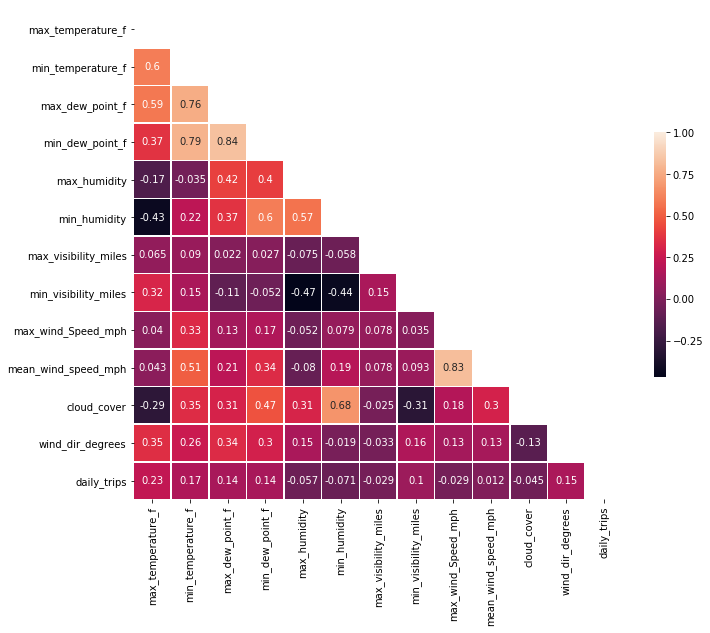

In [18]:
#weather.corr()
### Finding the Correlation between the Input at single Modal

feat = weather[['max_temperature_f','min_temperature_f','max_dew_point_f','min_dew_point_f','max_humidity','min_humidity','max_visibility_miles','min_visibility_miles','max_wind_Speed_mph','mean_wind_speed_mph','cloud_cover','wind_dir_degrees','daily_trips']]
#feat = weather
corr = feat.corr(method='pearson')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5,  cbar_kws={"shrink": .5},annot=True)
          

It is visible from the above the Temprature have the highest statistical impact on Trips,

Moreover, from the tableau sheet, Exploring SF Trips it was visible that the Feb and Dec are the least favoured day for bike and also have minimal temprature of whole year, similary Oct is most favoured and have maximum temprature of whole year.

Hence it can be said as the operator can be relaxed in minimum temprature months and highly active in maximum temprature months.

## Prediction Model and Evaluation

For the dynamic reallocation, a prediction model can be used to predict number of start trip, end trip, bikes available and Dock available.
Hence which can be used for reallocation by `Bikes_Required = Start_Trip - Bike Available - End Trip)` ,
and `if Bikes_Required > Docks_Available then Allocate_Bikes = Docks_Available - End_Trip else Bike_Required`

Note : `Bikes_Required = Start Trips on Station` 


In [19]:
feat_start_trip_new.columns

Index([                    'Start_Hour',                         'date_f',
                     'start_station_id',                     'is_weekday',
                                      0,                   'date_u_merge',
                                 'date',              'max_temperature_f',
                   'mean_temperature_f',              'min_temperature_f',
                      'max_dew_point_f',               'mean_dew_point_f',
                      'min_dew_point_f',                   'max_humidity',
                        'mean_humidity',                   'min_humidity',
        'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
        'min_sea_level_pressure_inches',           'max_visibility_miles',
                'mean_visibility_miles',           'min_visibility_miles',
                   'max_wind_Speed_mph',            'mean_wind_speed_mph',
                          'cloud_cover',                         'events',
                     'win

In [20]:
feat = ['Start_Hour','start_station_id','is_weekday','max_temperature_f','min_temperature_f','max_dew_point_f','min_dew_point_f','max_humidity','min_humidity','max_visibility_miles','min_visibility_miles','max_wind_Speed_mph','mean_wind_speed_mph','cloud_cover','wind_dir_degrees','Fog','Rain','Fog-Rain','Normal','Rain-Thunderstorm']
X = feat_start_trip_new[feat]
Y = feat_start_trip_new[0]
print(X.shape)
print(Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 2)


(237028, 20)
(237028,)


###  Essential Functions for Evaluation and Presentation

In [21]:
def cal_rmse(y_pred, y_true):
    """
        calculate root mean square error based on predicted and true result.
    """
    return np.sqrt(np.sum((y_pred - y_true)**2 / len(y_pred)))

def visualize_pred(y_pred, y_test, model_name ):
    """
        Visualize predicted result for randomly selected samples
    """
    vis_lst = [i for i in range(len(y_pred))]
    np.random.shuffle(vis_lst)
    y_test = y_test.reset_index()

    fig, ax = plt.subplots(figsize=(12,3))
    ax.set(xlabel='Samples', ylabel='Trips')
    plt.plot([range(len(y_pred[vis_lst[:100]])), range(len(y_test.loc[vis_lst[:100], 0]))], [y_pred[vis_lst[:100]], y_test.loc[vis_lst[:100], 0]], 'k-')
    ax.scatter(range(len(y_pred[vis_lst[:100]])),y_pred[vis_lst[:100]], label='Predicted Values', color = 'darkorange')
    ax.scatter(range(len(y_test.loc[vis_lst[:100], 0])),y_test.loc[vis_lst[:100], 0], label='Ground Truth', color = 'navy')
    plt.legend(loc="upper right")
    plt.show()
    
##visualize_feature(feat,clf.feature_importances_)  
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.title('Feature Importance')
    plt.show()
    

def plot_fold_performance(rmse):
    """
        Plot root mean square error based on model validation 
    """
    print('Standard Deviation = ',np.std(rmse))
    fig, ax = plt.subplots(figsize=(12,3))
    ax.set(xlabel='Iterations', ylabel='RMS Error',
    title='Performance of the 4 Folds Validation')
    x=range(len(rmse))
    y=np.around(rmse,decimals= 2)
    ax.plot(x,y)
    for i,j in zip(x,y):
        ax.annotate(str(j),xy=(i,j))
    
    plt.show()

RMSE =  1.6748212573010075


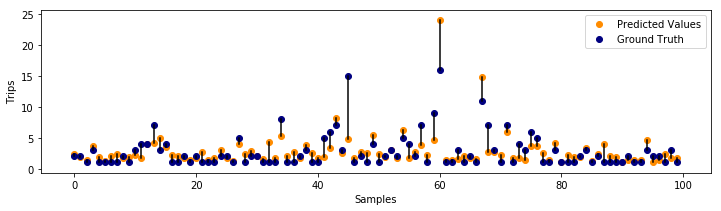

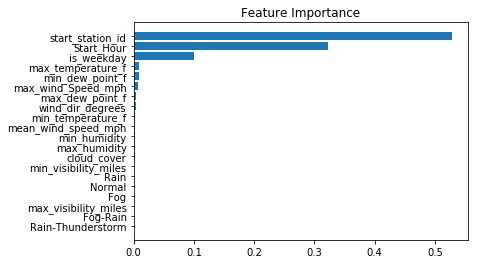

In [22]:
opt_params = {'max_depth' : 10, 'n_estimators' : 100, 'random_state' : 2}
regr = RandomForestRegressor(**opt_params)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print('RMSE = ',cal_rmse(y_pred, y_test))
visualize_pred(y_pred, y_test,'Random Forest')
f_importances(regr.feature_importances_,feat)

RMSE =  1.6655682953823314
RMSE =  1.7282025630841362
RMSE =  1.6997328382261239
RMSE =  1.6808021292600612
RMSE =  1.7129858847925186
RMSE =  1.6895933080948202
RMSE =  1.6858521073338288
RMSE =  1.6916868455958294
RMSE =  1.6921398423275356
RMSE =  1.68548476160793
RMSE =  1.6973774517321603
RMSE =  1.696383808649321
Standard Deviation =  0.015081738


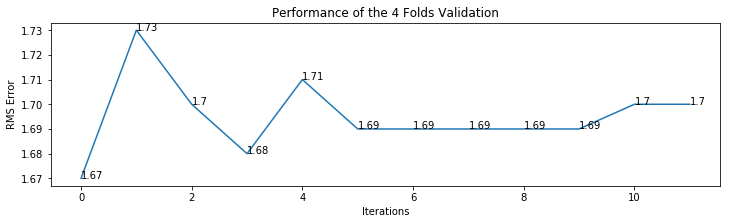

In [23]:
kf = RepeatedKFold(n_splits=4, n_repeats=3, random_state=None) 
opt_params = {'max_depth' : 10, 'n_estimators' : 100, 'random_state' : 2}
regr = RandomForestRegressor(**opt_params)
temp_rmse = array.array('f')
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    rmse = cal_rmse(y_pred, y_test)
    temp_rmse.append(rmse)
    print('RMSE = ',rmse)
plot_fold_performance(temp_rmse)

### Results looks good after model evaluation but their are still scope. 
### Inference
1. As per current model, StationId, week day, Start day, temprature highly important for prediction of trips.
2. Cross Validation gives results where SD is very low hence we can said prediction is stable.

Other models can be used for efficiency like XG Boost or ANN, and can be optimized using different approaches.

Model for other metrices can be created using same approach and finally a way optimized way can be approached to the Operator on real time.
Moreover, status file is being skipped but have good use for prediction for other metrices like dock available and bike available, which is not covered in this work.